In [38]:
import pandas as pd
from wordcloud import WordCloud
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# sklearn vectorizers 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
#modeling and dimensionality reduction for visuaization
from sklearn.decomposition import NMF
from sklearn.manifold import TSNE

# visualizations 
import seaborn as sns 
sns.set_style('darkgrid')
import plotly.express as px

In [2]:
# our processed dataset and corpus with all our lemmatized tokens 
spotify_df = pd.read_csv('data/preprocessed-reviews.csv')
corpus = pd.read_csv('data/spotify-reviews.csv')

In [3]:
# our tokenized wordsfrom preprocessed data
# we'll need to rename our column to prevent future confusion
corpus = corpus.rename(columns={'review':'tokens'})
corpus.head()

,tokens
0,great music service audio high quality app eas...
1,please ignore previous negative rating app sup...
2,get best spotify experience android annoy plea...
3,really buggy terrible use recently
4,dear spotify get song put playlist shuffle play


In [4]:
# our cleaned dataset with sentiment labels
spotify_df.head()

,review,rating,total_thumbs_up,replied,comp_score,pos_score,neg_score,sentiment
0,"great music service, the audio is high quality...",5,2,0,0.9211,0.436,0.000,pos
1,please ignore previous negative rating. this a...,5,1,0,0.6249,0.404,0.243,pos
2,"this pop-up ""get the best spotify experience o...",4,0,0,0.5859,0.258,0.107,pos
3,really buggy and terrible to use as of recently,1,1,0,-0.5209,0.000,0.296,neg
4,dear spotify why do i get songs that i didn't ...,1,1,0,0.7149,0.260,0.000,pos


## EDA 

### Class Imbalance 

<Axes: xlabel='sentiment', ylabel='Count'>

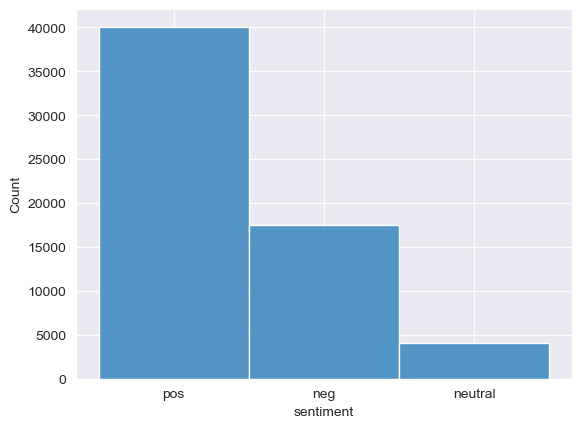

In [5]:
# since we are building a binary sentiment analysis classifier, need to look at class imbalance 
sns.histplot(x='sentiment', data=spotify_df)

### Correlation Matrix with all Numeric Features

In [6]:
# correlation between numeric features 
spotify_df.corr(numeric_only=True)

,rating,total_thumbs_up,replied,comp_score,pos_score,neg_score
rating,1.000000,-0.023966,-0.026375,0.558610,0.589197,-0.418237
total_thumbs_up,-0.023966,1.000000,0.006902,0.004895,-0.032150,0.003423
replied,-0.026375,0.006902,1.000000,-0.021207,-0.025088,0.017654
comp_score,0.558610,0.004895,-0.021207,1.000000,0.709050,-0.710155
pos_score,0.589197,-0.032150,-0.025088,0.709050,1.000000,-0.427821
neg_score,-0.418237,0.003423,0.017654,-0.710155,-0.427821,1.000000


No numeric features seem to be highly correlated with each other except for `pos_score` and `neg_score` with `comp_score` which is explained by the fact that `comp_score` is the result of an aggregation between the different polarity scores.

### Review Sentiment & Users' Ratings

-  Is there a relationship between users' sentiment and the rating provided?

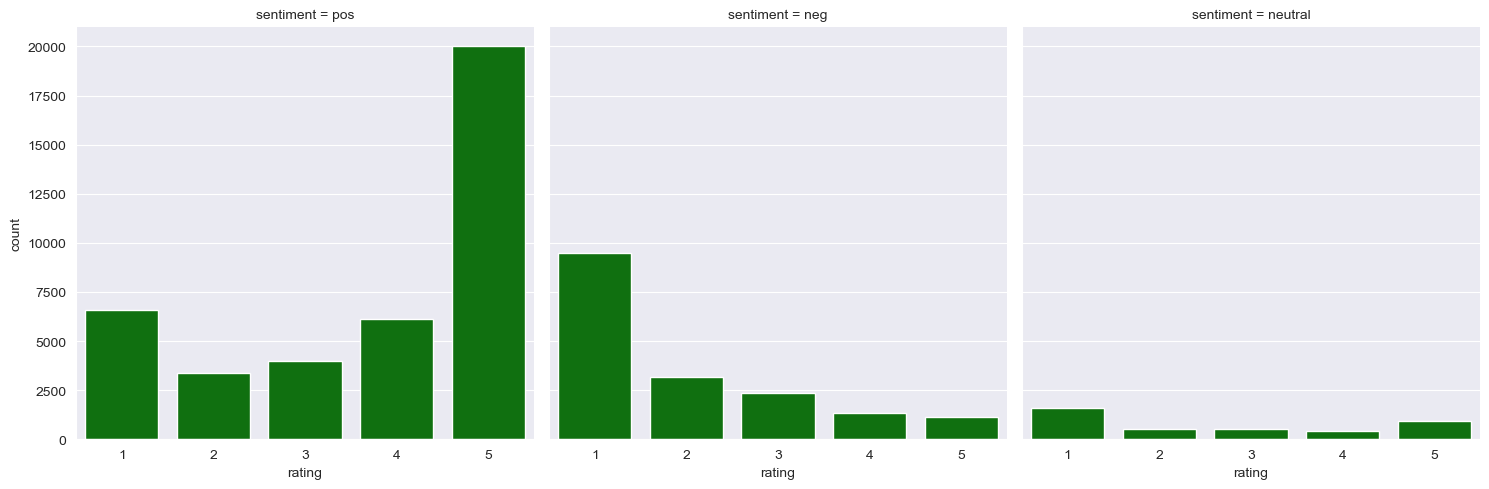

<Figure size 640x480 with 0 Axes>

In [7]:
# seeing the product rating by each sentiment label 
sns.catplot(data=spotify_df,x='rating',kind='count', col='sentiment', color='green')
plt.show()
plt.tight_layout()

Findings: 
- reviews with positive and negative sentiments all have ratings between 1 and 5
- reviews with a 'positive' sentiment have the majority of ratings between 3 and 5, with the median rating being 4 stars 
- reviews with a 'negative' sentiment have the majority of ratings between 1 and 3, with a median score of 1. 

### Relationship between Rating & Service Response

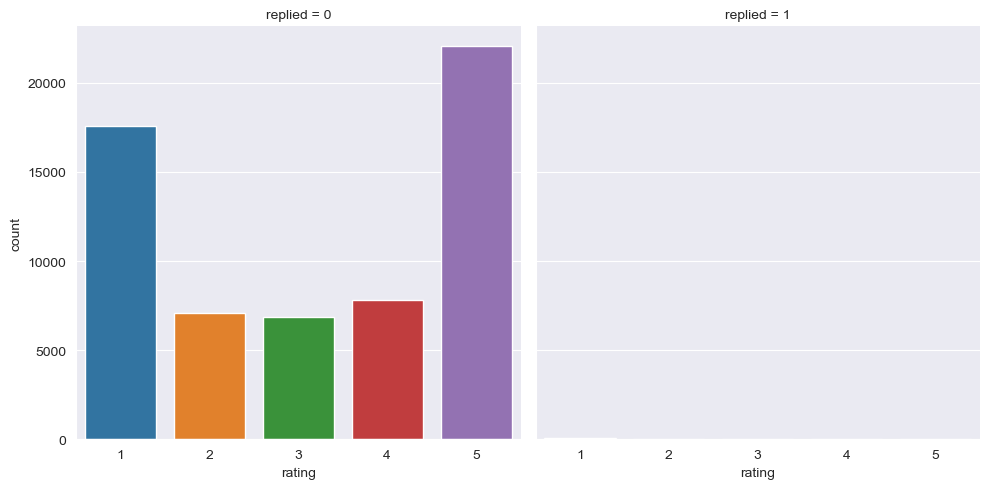

In [8]:
# visualizing the rx between rating and whether spotify replied to review 
sns.catplot(data=spotify_df,x='rating',kind='count', col='replied')
plt.show()

### Distribution of App Ratings

<Axes: xlabel='rating', ylabel='count'>

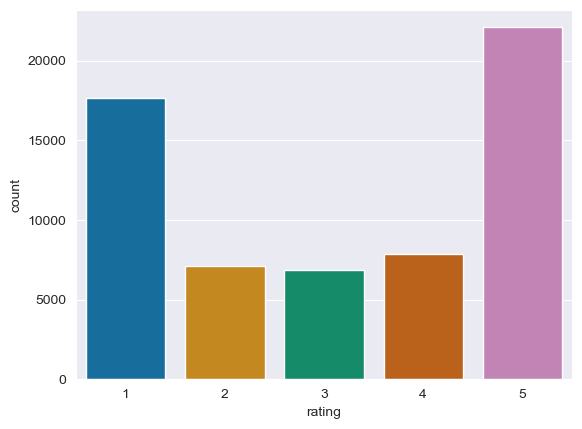

In [9]:
# a handy count plot 
sns.countplot(data=spotify_df,x='rating',palette='colorblind')

## WordClouds

### Generating WordClouds for Positive & Negative Reviews 

For our analysis, we'll want to create a visual representation of words that are in positive and negative sentiment reviews. To do so, we'll use `TfidfVectorizer` to extract words that are important. 

We'll need to concatenate our two dataframes so that we have a way to create a dataframe containing only positive and negative sentiment reviews as well as their tokenized words.

In [10]:
# concatenating our two dataframes 
spotify_reviews = pd.concat([spotify_df,corpus], axis=1)

# visually inspecting it
spotify_reviews.head()

,review,rating,total_thumbs_up,replied,comp_score,pos_score,neg_score,sentiment,tokens
0,"great music service, the audio is high quality...",5,2,0,0.9211,0.436,0.000,pos,great music service audio high quality app eas...
1,please ignore previous negative rating. this a...,5,1,0,0.6249,0.404,0.243,pos,please ignore previous negative rating app sup...
2,"this pop-up ""get the best spotify experience o...",4,0,0,0.5859,0.258,0.107,pos,get best spotify experience android annoy plea...
3,really buggy and terrible to use as of recently,1,1,0,-0.5209,0.000,0.296,neg,really buggy terrible use recently
4,dear spotify why do i get songs that i didn't ...,1,1,0,0.7149,0.260,0.000,pos,dear spotify get song put playlist shuffle play


In [11]:
spotify_reviews.sentiment.value_counts(normalize=True)

pos        0.650469
neg        0.284248
neutral    0.065282
Name: sentiment, dtype: float64

Now, we have our complete dataframe with our sentiment labels and the lemmatized tokens for each review. Time to extract only the positive and negative reviews!

In [12]:
# creating separate dataframes for positive and negative reviews using the sentiment labels 
pos_reviews = spotify_reviews[spotify_reviews.sentiment.str.contains('pos')]
neg_reviews = spotify_reviews[spotify_reviews.sentiment.str.contains('neg')]

In [13]:
pos_reviews.head()

,review,rating,total_thumbs_up,replied,comp_score,pos_score,neg_score,sentiment,tokens
0,"great music service, the audio is high quality...",5,2,0,0.9211,0.436,0.000,pos,great music service audio high quality app eas...
1,please ignore previous negative rating. this a...,5,1,0,0.6249,0.404,0.243,pos,please ignore previous negative rating app sup...
2,"this pop-up ""get the best spotify experience o...",4,0,0,0.5859,0.258,0.107,pos,get best spotify experience android annoy plea...
4,dear spotify why do i get songs that i didn't ...,1,1,0,0.7149,0.260,0.000,pos,dear spotify get song put playlist shuffle play
6,i love the selection and the lyrics are provid...,5,0,0,0.6696,0.257,0.000,pos,love selection lyric provide song listening


We've created a dataframe for only positive and negative reviews. Now, to better visualize our tokens (which are words in their root form) and determine which are important, we'll use `TfidfVectorizer` to assign weights, cut words that appear too frequently or are too rare, and plot a WordCloud! 

In [16]:
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS

In [23]:
def show_wordcloud(text):
    # instantiating our vectorizer 
    tfidf_vect = TfidfVectorizer(min_df=0.05,max_df=0.95)

    # transforming our positive review tokens 
    # this creates a sparse matrix which we will need to densify later 
    toks_transformed = tfidf_vect.fit_transform(text.tokens)

    # creating a tfidf matrix 
    # getting the words from our vectorizer (features)
    rv_words = tfidf_vect.get_feature_names_out()

    # taking our transformed sparse matrix and creating a dataframe 
    rv_wrd_list = toks_transformed.todense().tolist()
    rv_df = pd.DataFrame(rv_wrd_list, columns=rv_words)
    
    # time to generate our WordCloud! 
    rv_wrd_freq = rv_df.T.sum(axis=1)
    
    # creating our custom stopwords 
    stop_wrds = list(STOPWORDS) + ['app','spotify']

    # instantiating our WordCloud function
    wordcloud = WordCloud(background_color='white',color_func=lambda *args, **kwargs: "green",
                          stopwords=stop_wrds)

    # generating our WordCloud from our Tfidf matrix 
    wordcloud.generate_from_frequencies(rv_wrd_freq)
    
    # time to show our WordCloud! 
    plt.imshow(wordcloud,interpolation='bilinear')
    plt.axis('off')
    #plt.savefig('images/positive-reviews-wc.png',dpi=300)
    #plt.savefig('images/negative-reviews-wc.png',dpi=300)
    return 

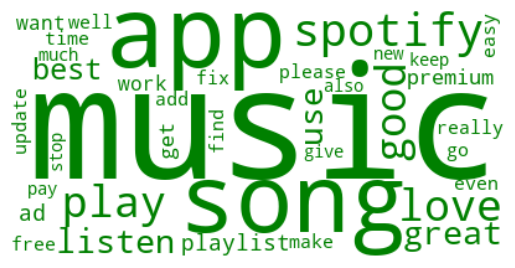

In [24]:
show_wordcloud(pos_reviews)

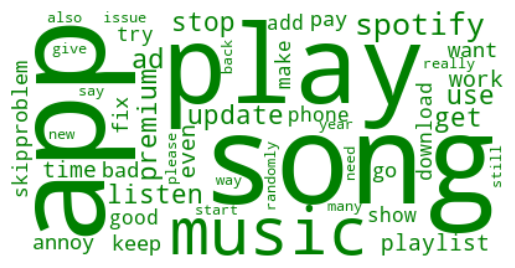

In [25]:
show_wordcloud(neg_reviews)

In [26]:
# instantiating our vectorizer 
tfidf_vect = TfidfVectorizer(min_df=0.05,max_df=0.95)

# transforming our positive review tokens 
# this creates a sparse matrix which we will need to densify later 
pos_rv_words = tfidf_vect.fit_transform(pos_reviews.tokens)

In [27]:
# creating a tfidf matrix 
# getting the words from our vectorizer (features)
pos_words = tfidf_vect.get_feature_names_out()

# taking our transformed sparse matrix and creating a dataframe 
# each row represents a review 
# each column represents a token and the values are weights assigned by TFIDF
pos_wrd_lst = pos_rv_words.todense().tolist()
pos_rv_df = pd.DataFrame(pos_wrd_lst,columns=pos_words)

(-0.5, 399.5, 199.5, -0.5)

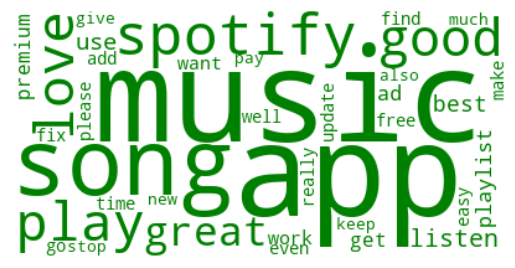

In [28]:
# time to generate our WordCloud! 
pos_wrd_freq = pos_rv_df.T.sum(axis=1)

# instantiating our WordCloud function
wordcloud = WordCloud(background_color='white',color_func=lambda *args, **kwargs: "green")


# generating our WordCloud from our Tfidf matrix 
wordcloud.generate_from_frequencies(pos_wrd_freq)

plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')

### Visualizing Noun Phrases with WordCloud

In [17]:
# we'll need to update our stop_words for noun_phrases 
custom_stopwrds = list(STOPWORDS) + ['app','spotify','i_dont','i_cant','i_use','i_pay','_i']

In [29]:
pos_text = str(pos_reviews.review.to_list())
pos_text = pos_text.replace("\'","").replace("[","").replace("]","")
type(pos_text)

str

In [30]:
import random
a = pos_reviews.review.to_list()
a1 = random.sample(a, 2000)
b = neg_reviews.review.to_list()
b1 = random.sample(b,2000)
c = str(b1).replace("\'","").replace("[","").replace("]","")
d = str(a1).replace("\'","").replace("[","").replace("]","")

In [31]:
pos_rvs_blob = TextBlob(d)
pos_noun_phrases = pos_rvs_blob.noun_phrases

In [32]:
pos_noun_list = []
for noun in pos_noun_phrases:
    pos_noun_list.append(noun.replace(' ','_'))
pos_noun_str = ' '.join(pos_noun_list)

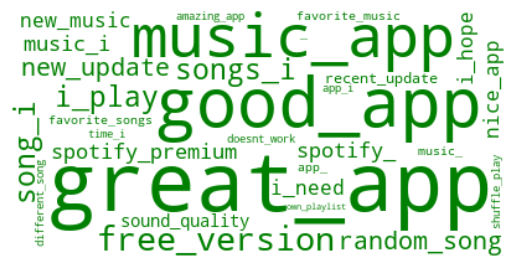

In [33]:
wc = WordCloud(max_words=30,stopwords=custom_stopwrds,background_color='white',
               color_func=lambda *args, **kwargs: "green")
wc.generate(pos_noun_str)
plt.axis('off')
plt.imshow(wc,interpolation='bilinear')
#plt.savefig('images/positive_reviews_nounphrases.png',dpi=300)

In [34]:
neg_rvs_blob = TextBlob(c)
neg_noun_phrases = neg_rvs_blob.noun_phrases

In [238]:
neg_noun_list = []
for noun in neg_noun_phrases:
    neg_noun_list.append(noun.replace(' ','_'))
neg_noun_str = ' '.join(neg_noun_list)

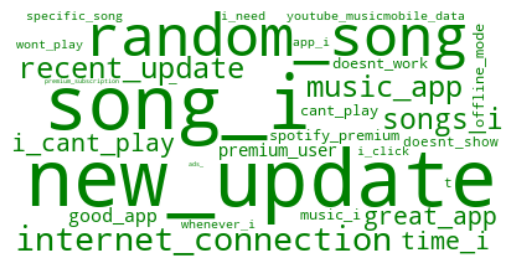

In [241]:
wc = WordCloud(max_words=30,stopwords=custom_stopwrds,background_color='white',
               color_func=lambda *args, **kwargs: "green")
wc.generate(neg_noun_str)
plt.axis('off')
plt.imshow(wc,interpolation='bilinear')
#plt.savefig('images/negative_reviews_nounphrases.png',dpi=300)

### Modeling Bi-Grams of Positive Reviews

In [39]:
vec = CountVectorizer(ngram_range=(2,2),min_df=.001,max_df=.85,stop_words=custom_stopwrds)

In [40]:
pos_X = vec.fit_transform(pos_reviews.tokens)

C:\Users\Kevin\anaconda3\envs\spotify-proj\Lib\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


In [41]:
pos_model = NMF(n_components=4,random_state=42)
pos_model.fit(pos_X)

NMF(n_components=4, random_state=42)

In [42]:
P_H = pos_model.transform(pos_X)
P_W = pos_model.components_

In [43]:
for index,topic in enumerate(P_W):
    print(f'THE TOP 10 WORDS FOR TOPIC #{index}')
    print([vec.get_feature_names_out()[i] for i in topic.argsort()[-25:]])
    print('\n')

THE TOP 10 WORDS FOR TOPIC #0
['new update', 'skip song', 'music play', 'play list', 'keep play', 'go back', 'different song', 'play play', 'stop play', 'even play', 'song song', 'play playlist', 'play random', 'shuffle play', 'start play', 'playlist play', 'random song', 'song even', 'want play', 'play music', 'try play', 'please fix', 'song playlist', 'song play', 'play song']


THE TOP 10 WORDS FOR TOPIC #1
['music even', 'use listen', 'make playlist', 'good music', 'music play', 'music love', 'music ad', 'please fix', 'able listen', 'enjoy listen', 'many ad', 'really good', 'music listen', 'easy use', 'way listen', 'music podcasts', 'give star', 'want listen', 'play music', 'music want', 'great listen', 'love listen', 'good listen', 'best listen', 'listen music']


THE TOP 10 WORDS FOR TOPIC #2
['highly recommend', 'music best', 'good music', 'music streaming', 'use year', 'music lover', 'music experience', 'far best', 'sound quality', 'stream platform', 'play music', 'new music', 

In [46]:
%%capture topic_word_plot
def plot_top_words(W, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, 4, figsize=(20, 10), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(P_W):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 25})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=15)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=25)

    plt.subplots_adjust(top=0.85, bottom=0.05, wspace=0.90, hspace=0.3)
    #plt.savefig('images/positive-reviews-topics',dpi=300)
    plt.show()

n_top_words =5
count_vec_feature_names = vec.get_feature_names_out()
plot_top_words(P_W, count_vec_feature_names, n_top_words, "Positive Reviews Topic Modeling",)

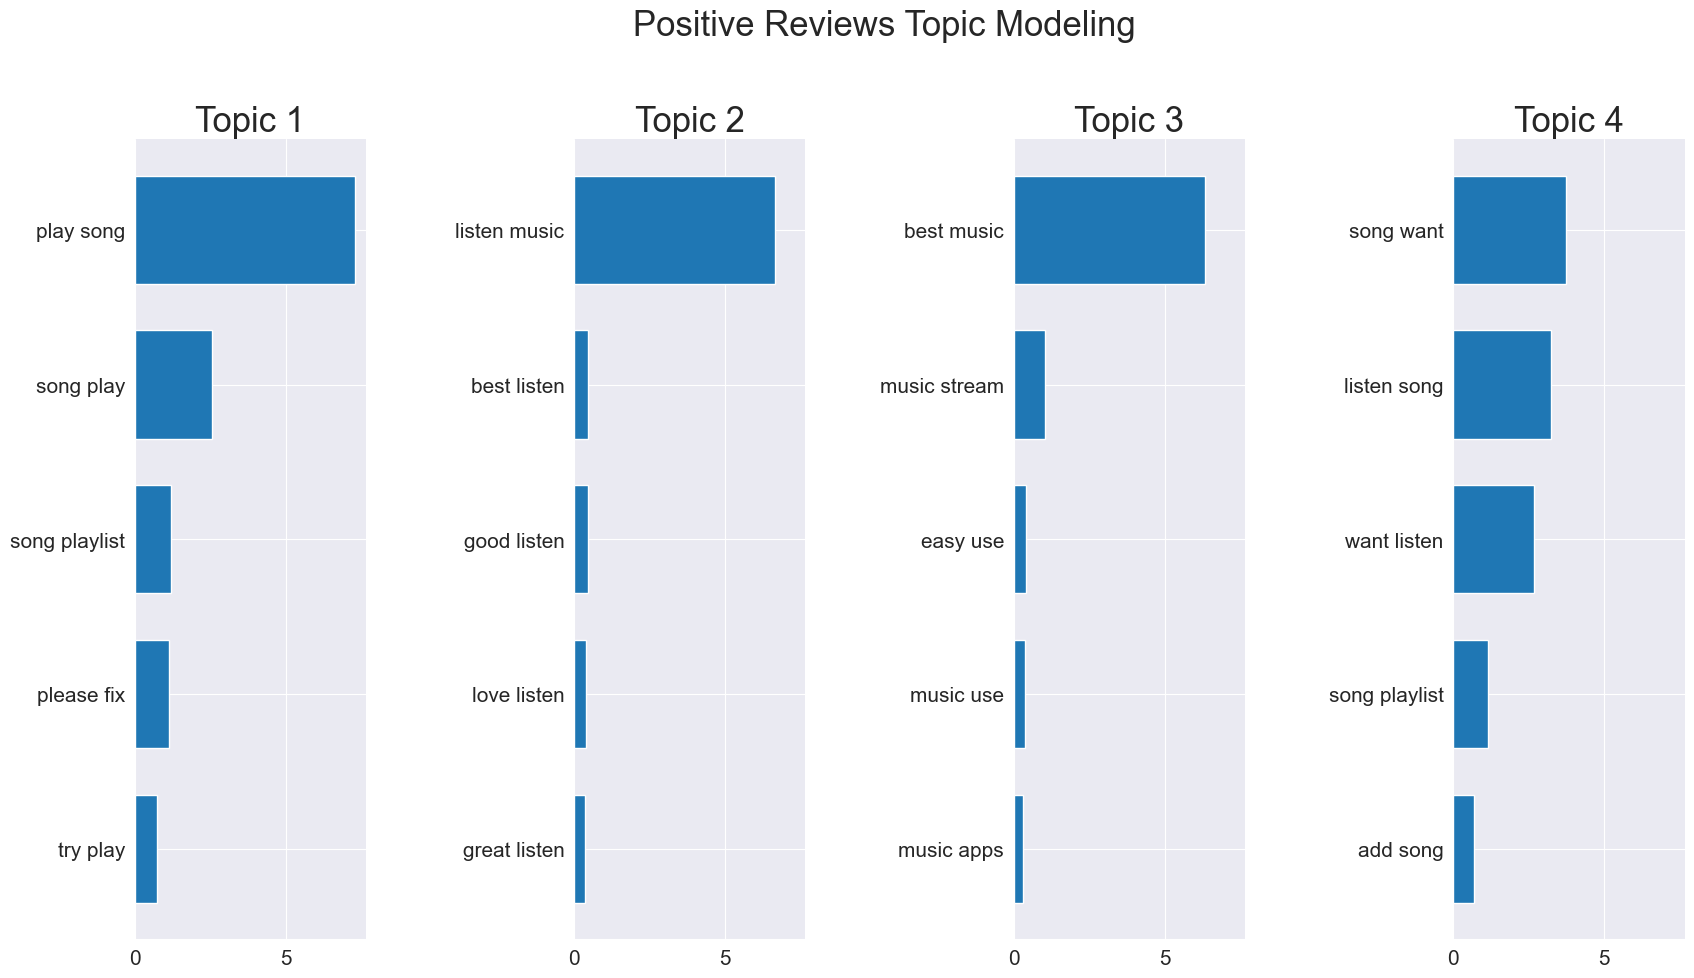

In [47]:
topic_word_plot()

Using bi-grams to map out the positive reviews, we can see that there are some latent themes present, however it's unclear what they are using as a reference.

## Topic Modeling Tri-grams

In [48]:
tri_vec = CountVectorizer(ngram_range=(3,3),min_df=.001,max_df=.85,stop_words=custom_stopwrds)
tri_BOW = tri_vec.fit_transform(pos_reviews.tokens).toarray()
tri_columns = tri_vec.get_feature_names_out()
tri_pos_df = pd.DataFrame(data=tri_BOW, columns=tri_columns)

C:\Users\Kevin\anaconda3\envs\spotify-proj\Lib\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


In [49]:
tri_pos_X = tri_vec.fit_transform(pos_reviews.tokens)

In [50]:
tri_pos_model = NMF(n_components=4,random_state=42)
tri_pos_model.fit(tri_pos_X)

NMF(n_components=4, random_state=42)

In [51]:
tri_H = tri_pos_model.transform(tri_pos_X)
tri_W = tri_pos_model.components_

In [52]:
tri_W.shape

(4, 94)

In [53]:
for index,topic in enumerate(tri_W):
    print(f'THE TOP 10 TRIGRAMS FOR TOPIC #{index}')
    print([tri_vec.get_feature_names_out()[i] for i in topic.argsort()[-25:]])
    print('\n')

THE TOP 10 TRIGRAMS FOR TOPIC #0
['way many ad', 'ad free music', 'start play song', 'song start play', 'play song song', 'add random song', 'listen song ad', 'listen music want', 'keep play song', 'song want hear', 'song playlist play', 'play different song', 'want listen music', 'please fix issue', 'play song want', 'play suggest song', 'find song want', 'add song playlist', 'even listen song', 'song listen song', 'pick song want', 'choose song want', 'want listen song', 'listen song want', 'song want listen']


THE TOP 10 TRIGRAMS FOR TOPIC #1
['add random song', 'please fix problem', 'play favorite song', 'playlist play song', 'song playlist play', 'find song want', 'please fix bug', 'start play song', 'keep play song', 'play song even', 'play song song', 'play specific song', 'add song playlist', 'song please fix', 'song want hear', 'let play song', 'even play song', 'play song playlist', 'song play song', 'play different song', 'pick song want', 'want play song', 'choose song wan

In [54]:
%%capture topic_word_plot
def plot_top_words(W, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, 4, figsize=(20, 10), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(tri_W):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 25})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=15)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=25)

    plt.subplots_adjust(top=0.85, bottom=0.05, wspace=0.90, hspace=0.3)
    #plt.savefig('images/positive-reviews-topics',dpi=300)
    plt.show()

n_top_words =5
count_vec_feature_names = tri_vec.get_feature_names_out()
plot_top_words(tri_W, count_vec_feature_names, n_top_words, "Positive Reviews Topic Modeling",)

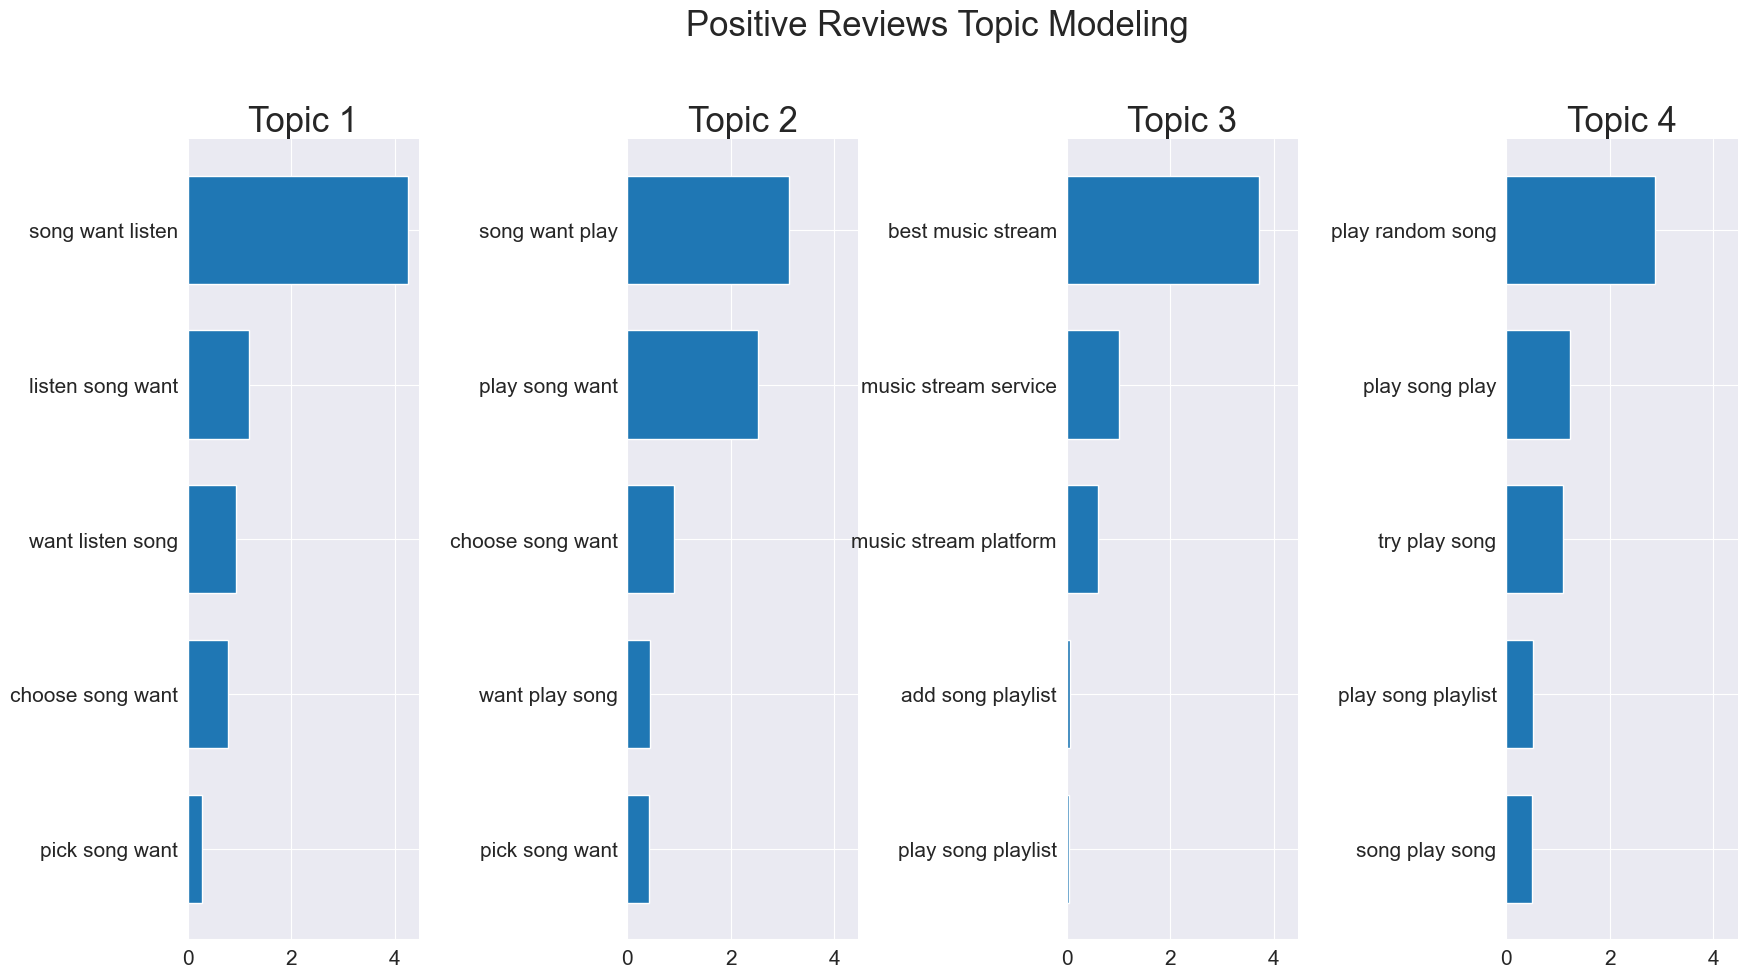

In [55]:
topic_word_plot()

## Topic Modeling - Negative Reviews Tri-Grams

In [56]:
neg_tri_vec = CountVectorizer(ngram_range=(3,3),min_df=.001,max_df=.85,stop_words=custom_stopwrds)
neg_tri_BOW = tri_vec.fit_transform(neg_reviews.tokens).toarray()
neg_tri_columns = tri_vec.get_feature_names_out()
tri_neg_df = pd.DataFrame(data=tri_BOW, columns=tri_columns)

In [57]:
tri_neg_X = neg_tri_vec.fit_transform(neg_reviews.tokens)

C:\Users\Kevin\anaconda3\envs\spotify-proj\Lib\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


In [58]:
tri_neg_model = NMF(n_components=2,random_state=42)
tri_neg_model.fit(tri_neg_X)

NMF(n_components=2, random_state=42)

In [59]:
tri_neg_H = tri_neg_model.transform(tri_neg_X)
tri_neg_W = tri_neg_model.components_

In [60]:
tri_neg_W.shape

(2, 151)

In [61]:
for index,topic in enumerate(tri_neg_W):
    print(f'THE TOP 10 TRIGRAMS FOR TOPIC #{index}')
    print([tri_vec.get_feature_names_out()[i] for i in topic.argsort()[-25:]])
    print('\n')

THE TOP 10 TRIGRAMS FOR TOPIC #0
['song playlist play', 'song playlist even', 'play specific song', 'song please fix', 'play suggest song', 'new update suck', 'try play song', 'play song even', 'start play song', 'song play playlist', 'song want playlist', 'play song play', 'play song playlist', 'song play song', 'play different song', 'song want hear', 'want play song', 'cant play song', 'song want shuffle', 'cant even play', 'play random song', 'let play song', 'even play song', 'song want play', 'play song want']


THE TOP 10 TRIGRAMS FOR TOPIC #1
['hate new update', 'try play song', 'want listen music', 'song want hear', 'listen song playlist', 'song add song', 'play specific song', 'playlist add song', 'song playlist annoy', 'stop add song', 'song playlist want', 'even listen song', 'add song want', 'let listen song', 'keep add song', 'play random song', 'add random song', 'want listen playlist', 'random song playlist', 'choose song want', 'pick song want', 'want listen song', 'li

In [65]:
%%capture topic_word_plot
def plot_top_words(W, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, 2, figsize=(20, 10), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(tri_neg_W):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 25})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=15)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=25)

    plt.subplots_adjust(top=0.85, bottom=0.05, wspace=0.90, hspace=0.3)
    #plt.savefig('images/positive-reviews-topics',dpi=300)
    plt.show()

n_top_words =5
count_vec_feature_names = neg_tri_vec.get_feature_names_out()
plot_top_words(tri_neg_W, count_vec_feature_names, n_top_words, "Negative Reviews Topic Modeling",)

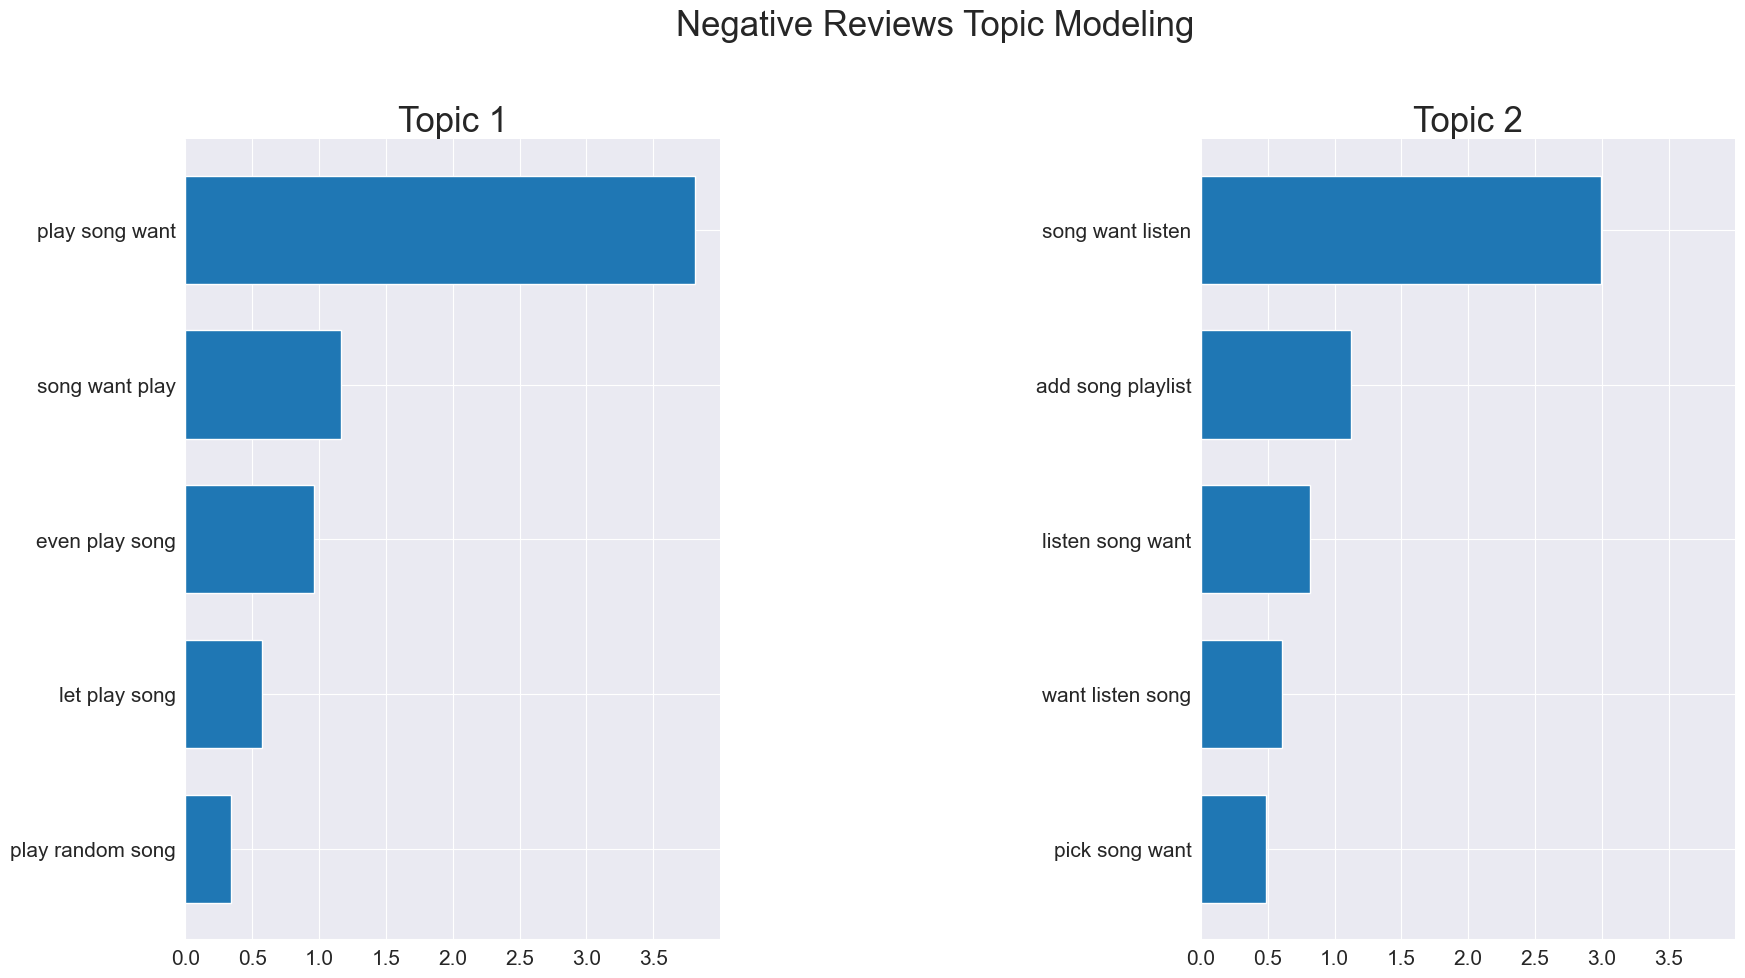

In [66]:
topic_word_plot()

### TSNE 

In [67]:
from sklearn.manifold import TSNE

In [71]:
tsne = TSNE(random_state=42, learning_rate=100)
tsnes_trans = tsne.fit_transform(P_H)

In [72]:
tsnes_trans = pd.DataFrame(tsnes_trans, columns = ['TSNE1', 'TSNE2'])
tsnes_trans

,TSNE1,TSNE2
0,9.636312,43.276863
1,8.899055,-8.339646
2,-22.597477,-29.233540
3,19.068523,6.092284
4,8.899055,-8.339646
...,...,...
40060,0.644266,-10.970634
40061,44.428024,-12.443550
40062,49.008106,-4.090105
40063,47.875954,-33.350380


In [73]:
topic_name_dict = {0:'music library',1:'ux customization',2:'playlists',3:'algorithm'}

In [76]:
# for each document takes the topic with highest weight and assigns document to this class -- hard clustering.
tsnes_trans['class'] = np.argmax(P_H, axis = 1)
tsnes_trans['class'] = tsnes_trans['class'].replace(topic_name_dict)

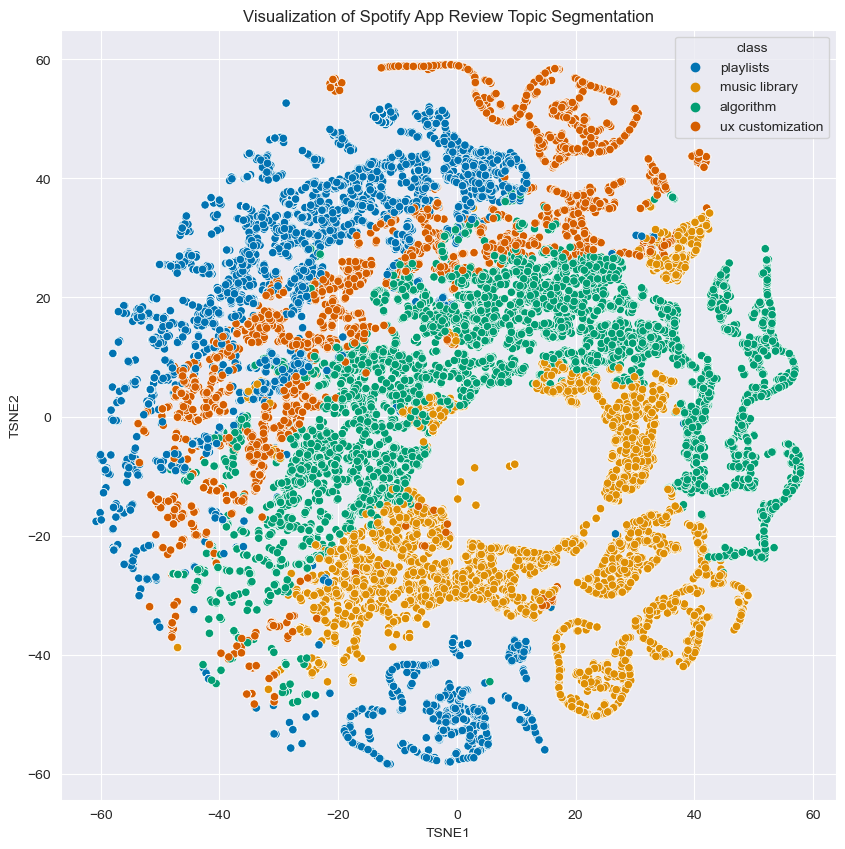

In [77]:
plt.figure(figsize=(10,10))
sns.scatterplot(x = 'TSNE1', y = 'TSNE2', hue = 'class', data = tsnes_trans, palette = 'colorblind')
plt.title('Visualization of Spotify App Review Topic Segmentation')
plt.show()